In [1]:
import numpy as np
import pandas as pd
from imageio import imread
from skimage import data
import matplotlib.pyplot as plt
import os
from skimage.transform import resize


#loading image
#carregando o arquivo
photo_data = imread("./images/mdb001.pgm")
im = np.array(photo_data) #[:,:,0])

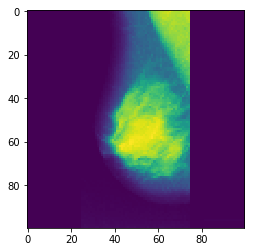

(100, 100)


In [2]:
im = resize(im,(100,100),mode='reflect')
plt.imshow(im)
plt.show()
print(im.shape)

In [3]:
resize(im,(100,100),mode='reflect')

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [4]:
results = pd.read_csv('results_clean.csv')

In [5]:
results.head()

,id,tissue,anomaly,severity,x_abnorm,y_abnorm,abn_radius
0,mdb001,G,CIRC,1,535,425,197.0
1,mdb002,G,CIRC,1,522,280,69.0
2,mdb003,D,NORM,0,0,0,0.0
3,mdb004,D,NORM,0,0,0,0.0
4,mdb005,F,CIRC,1,477,133,30.0


In [6]:
path = "images/"
Xlist = []
Ylist = results['severity']

new_size=(200,200)

for file in os.listdir(path)[:]:
    #print(path+file)
    photo_data = imread(path+file) #(path+"/"+file)
    photo_data = resize(photo_data,new_size,mode='reflect')
    featurevector = np.array(photo_data)
    Xlist.append(featurevector.flatten())
        

X = np.array(Xlist)
Y = np.array(Ylist)

In [11]:
X.shape

(322, 40000)

In [10]:
results.severity.shape

(322,)

In [9]:
results.tail()

,id,tissue,anomaly,severity,x_abnorm,y_abnorm,abn_radius
317,mdb318,D,NORM,0,0,0,0.0
318,mdb319,D,NORM,0,0,0,0.0
319,mdb320,D,NORM,0,0,0,0.0
320,mdb321,D,NORM,0,0,0,0.0
321,mdb322,D,NORM,0,0,0,0.0


## Modelling

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [13]:
clf = LogisticRegression(random_state=10000, 
                         solver= 'lbfgs',
                         multi_class='multinomial',
                         #max_iter=10000000000
                        )

scores_ac = cross_val_score(clf, X, Y,cv=10,scoring='accuracy')

print(scores_ac.mean())

0.486157351504


In [ ]:
scores_auc = cross_val_score(clf, X, Y,cv=10,scoring='recall')

print(scores_auc.mean())

In [ ]:
scores_precision = cross_val_score(clf, X, Y,cv=10,scoring='precision')

print(scores_precision.mean())

In [14]:
# Running tests in a single fit model:

clf2 = LogisticRegression(random_state=10000, 
                         solver='lbfgs',
                         multi_class='multinomial',
                         #max_iter=10000000000
                         )

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1000)
clf2.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000000000, multi_class='ovr',
          n_jobs=1, penalty='l2', random_state=10000, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
y0_pred = clf2.predict(X_test)
 
print('final train score:',clf2.score(X_train,Y_train))
print('final test score:',clf2.score(X_test,Y_test))

final train score: 1.0
final test score: 0.577319587629


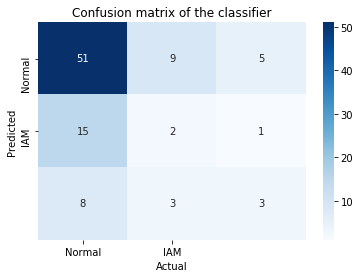

true positives: 2
true negatives: 51
false positives: 9
false negatives: 15
precision: 0.181818181818
sensitivity: 0.117647058824
specificity: 0.85


ValueError: multiclass format is not supported

In [16]:
# Plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['Normal', 'IAM']

conf_mat = confusion_matrix(y_true = Y_test,
                       y_pred = y0_pred)

#print(conf_mat)

cm = confusion_matrix(y_true = Y_test,
                      y_pred = y0_pred)


sns.heatmap(cm,
            annot = True,
            xticklabels = labels,
            yticklabels = labels,
            cmap = 'Blues')


plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix of the classifier')
plt.show()

# Plotting more model metrics:
print('true positives:',conf_mat[1,1])
print('true negatives:',conf_mat[0,0])
print('false positives:',conf_mat[0,1])
print('false negatives:',conf_mat[1,0])
print('precision:',(conf_mat[1,1]/(conf_mat[1,1]+conf_mat[0,1])))
print('sensitivity:',(conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0])))
print('specificity:',(conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])))

#######
# ROC AUC plot analysis: 

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

probs = clf2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)


# plotting the curve:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
